In [1]:
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import vice
import sys
sys.path.append("..")
from src.utils import subsample_stellar_populations, get_velocity_profile, oh_to_12pluslog
from src.plots.utils import weighted_median
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [16]:
outputs = [
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/dt0p005/gsebetaphiin-0p8",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/dt0p02/gsebetaphiin-0p8"
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:, -1][:out.stars.size[0]]]

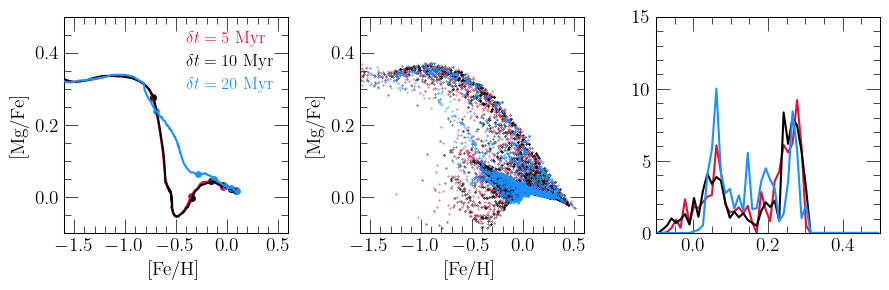

In [28]:
RADIUS = 8
COLORS = ["crimson", "black", "dodgerblue"]
TIMESTEP_SIZES = [0.005, 0.01, 0.02]

fig = plt.figure(figsize = (9, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"[Fe/H]")
    ax.set_ylabel(r"[Mg/Fe]")
    ax.set_xlim([-1.6, 0.6])
    ax.set_xticks([-1.5, -1, -0.5, 0, 0.5])
    ax.set_ylim([-0.1, 0.5])
ax3.set_xlim(ax1.get_ylim())
ax3.set_ylim([0, 15])

def plot_track(ax, output, radius, zone_width = 0.1, marklookbacks = [0, 2, 4, 6, 8, 10, 12], **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    ax.plot(zone.history["[fe/h]"], zone.history["[mg/fe]"], **kwargs)
    for i in range(len(marklookbacks)):
        diff = [abs(_ - marklookbacks[i]) for _ in zone.history["lookback"]]
        idx = diff.index(min(diff))
        _kwargs = {}
        if "c" in kwargs.keys(): _kwargs["color"] = kwargs["c"]
        _kwargs["marker"] = markers()["circle"]
        _kwargs["s"] = 15
        ax.scatter(zone.history["[fe/h]"][idx], zone.history["[mg/fe]"][idx], **_kwargs)

def plot_stars(ax_scat, ax_dist, output, rmin, rmax, abszmin, abszmax, fehmin, fehmax,
    zone_width = 0.1, N = 5000, seed = 0, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "mass", ">=", 1)
    stars = subsample_stellar_populations(stars, N = N, seed = seed)
    ax_scat.scatter(stars["[fe/h]"], stars["[mg/fe]"], **kwargs)
    stars = stars.filter(
        "[fe/h]", ">=", fehmin).filter(
        "[fe/h]", "<=", fehmax)
    hist, bins = np.histogram(stars["[mg/fe]"], bins = 50, range = ax_dist.get_xlim(),
        weights = stars["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    if "s" in kwargs.keys(): del kwargs["s"]
    ax_dist.plot(xvals, hist, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$\delta t = %g$ Myr" % (1000 * TIMESTEP_SIZES[i]),
        "zorder": 100
    }
    plot_track(ax1, outputs[i], RADIUS, **kwargs)
    kwargs["label"] = None
    kwargs["s"] = 0.1
    plot_stars(ax2, ax3, outputs[i], RADIUS - 1, RADIUS + 1, 0, 0.5, -0.4, -0.2, **kwargs)

kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
    "fontsize": 12
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.show()